In [1]:
import os
import torch
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
import logging
from torch.utils.tensorboard import SummaryWriter

In [2]:
torch.cuda.is_available()

True

In [3]:
logging.basicConfig(
    format="%(asctime)s - %(levelname)s: %(message)s",
    level=logging.INFO,
    datefmt="%I:%M:%S",
)


def setup_logging(run_name):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("models", run_name), exist_ok=True)
    os.makedirs(os.path.join("results", run_name), exist_ok=True)

# Data Preprocessing

In [4]:
from data.one_hot_descrete import DiscreteOneHotEncoder
from torch.utils.data import DataLoader


data = pd.read_csv("./data/nts_2021_acts_home_based.csv")
# data = pd.read_csv("./data/nts_toy_home_population.csv")

encoder = DiscreteOneHotEncoder(step_size=10)
encoded_data = encoder.encode(data)
print(encoder.acts_to_index)

dataloader = DataLoader(
    encoded_data,
    batch_size=256,
    num_workers=3,
    shuffle=True,
    persistent_workers=True,
)

{'home': 0, 'shop': 1, 'work': 2, 'escort': 3, 'other': 4, 'education': 5, 'visit': 6, 'medical': 7}


In [5]:
(x, x_mask) = encoded_data[10]
x.shape

torch.Size([1, 144, 8])

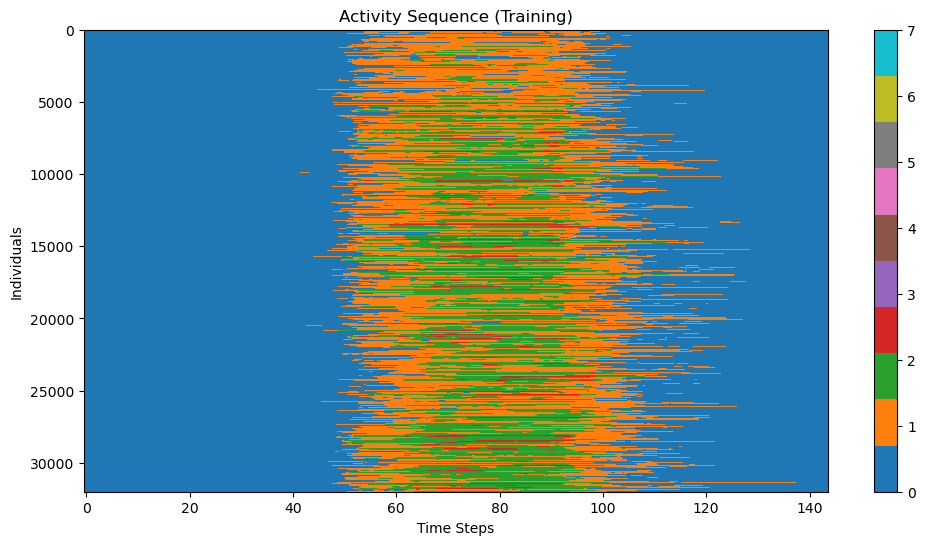

In [6]:
def plot_image_grid(image_grid, title="Activity Sequence (Training)"):
    plt.figure(figsize=(12, 6))
    plt.imshow(image_grid, aspect="auto", cmap="tab10")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Individuals")
    plt.show()


sample = [encoded_data[i][0].squeeze().argmax(dim=-1) for i in range(32000)]
plot_image_grid(sample)

# Diffusion

In [7]:
class Diffusion:
    def __init__(
        self,
        noise_steps=50,
        beta_start=0.0001,
        beta_end=0.02,
        sequence_length=144,
        device="cuda",
    ):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.sequence_length = sequence_length
        self.device = device

        self.beta = self.schedule_noise().to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def schedule_noise(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_embeddings(self, embeddings, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1.0 - self.alpha_hat[t])[:, None, None]

        epsilon = torch.randn_like(embeddings)

        noisy_embeddings = (
            sqrt_alpha_hat * embeddings + sqrt_one_minus_alpha_hat * epsilon
        )

        # Debug: Check for NaNs
        if torch.isnan(noisy_embeddings).any():
            print("NaNs detected in noisy_embeddings")
            print("sqrt_alpha_hat:", sqrt_alpha_hat)
            print("sqrt_one_minus_alpha_hat:", sqrt_one_minus_alpha_hat)
            print("epsilon:", epsilon)

        return noisy_embeddings.float(), epsilon.float()

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, embedding_dim):
        logging.info(f"Sampling {n} new sequences...")
        model.eval()
        with torch.no_grad():
            # Initialise x with the proper dimensions for sequence data.
            x = torch.randn((n, self.sequence_length, embedding_dim)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                # Adjust dimensions for alpha, alpha_hat, and beta to match x
                alpha = self.alpha[t][:, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None]
                beta = self.beta[t][:, None, None]

                if i > 50:
                    print("noise added")
                    noise = torch.randn_like(x)
                else:
                    print("no noise added")
                    noise = torch.zeros_like(x)

                x = (1 / torch.sqrt(alpha)) * (
                    x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * predicted_noise
                ) + torch.sqrt(beta) * noise

        model.train()
        return x

# Transformer

In [19]:
from models.transformer import TransformerWithPositionalEncoding

from models.cnn import Conv


def setup_logging(run_name):
    logging.basicConfig(level=logging.INFO)


def train(model, diffusion, device):
    run_name = "first_run"
    learning_rate = 0.0005
    epochs = 100

    setup_logging(run_name)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    x_entropy = nn.CrossEntropyLoss()
    logger = SummaryWriter(os.path.join("runs", run_name))

    for epoch in range(epochs):
        logging.info(f"Starting epoch {epoch}")
        epoch_loss = 0.0
        # for batch_idx, (x,) in enumerate(tqdm(dataloader)):
        for batch_idx, (x, x_mask) in enumerate(tqdm(dataloader)):
            x = x.squeeze(1)
            embedded_x = x.to(device)

            optimizer.zero_grad()
            timesteps = torch.randint(
                0, diffusion.noise_steps, (embedded_x.size(0),), device=device
            )
            embedded_x = embedded_x.float()
            noisy_x, _ = diffusion.noise_embeddings(embedded_x, timesteps)
            predicted_x = model(noisy_x, timesteps)

            loss = x_entropy(predicted_x.permute(0, 2, 1), noisy_x.argmax(dim=-1))

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Log training loss to TensorBoard every 10 batches
            if batch_idx % 10 == 0:
                logger.add_scalar(
                    "Loss/train", loss.item(), epoch * len(dataloader) + batch_idx
                )

        avg_epoch_loss = epoch_loss / len(dataloader)
        logging.info(f"Epoch {epoch} Average Loss: {avg_epoch_loss}")
        logger.add_scalar("Loss/epoch_avg_train", avg_epoch_loss, epoch)

    logger.close()


device = "cuda" if torch.cuda.is_available() else "cpu"

model = TransformerWithPositionalEncoding(num_layers=3, sequence_length=144).to(device)
# model = Conv(in_shape=(48, 8), hidden_layers=(32, 32), dropout=0.1).to(device)

diffusion = Diffusion(
    noise_steps=25, beta_start=0.0001, beta_end=0.02, sequence_length=144, device=device
)

train(model, diffusion, device)

02:59:44 - INFO: Starting epoch 0
  0%|          | 0/146 [00:00<?, ?it/s]

100%|██████████| 146/146 [00:08<00:00, 17.22it/s]
02:59:52 - INFO: Epoch 0 Average Loss: 1.4894902436700586
02:59:52 - INFO: Starting epoch 1
100%|██████████| 146/146 [00:07<00:00, 18.45it/s]
03:00:00 - INFO: Epoch 1 Average Loss: 0.8260283547721498
03:00:00 - INFO: Starting epoch 2
100%|██████████| 146/146 [00:08<00:00, 17.76it/s]
03:00:08 - INFO: Epoch 2 Average Loss: 0.5647176896056084
03:00:08 - INFO: Starting epoch 3
100%|██████████| 146/146 [00:08<00:00, 17.34it/s]
03:00:17 - INFO: Epoch 3 Average Loss: 0.45789496416914954
03:00:17 - INFO: Starting epoch 4
100%|██████████| 146/146 [00:07<00:00, 18.45it/s]
03:00:25 - INFO: Epoch 4 Average Loss: 0.3907417989756963
03:00:25 - INFO: Starting epoch 5
100%|██████████| 146/146 [00:07<00:00, 18.83it/s]
03:00:32 - INFO: Epoch 5 Average Loss: 0.34550467439710275
03:00:32 - INFO: Starting epoch 6
100%|██████████| 146/146 [00:07<00:00, 18.71it/s]
03:00:40 - INFO: Epoch 6 Average Loss: 0.3132029784052339
03:00:40 - INFO: Starting epoch 7
100%

KeyboardInterrupt: 

In [20]:
# After generating new sequences using the diffusion model
generated_sequences = diffusion.sample(model=model, n=128, embedding_dim=8)

# Map the generated sequences back to discrete activities
discrete_activities = generated_sequences.argmax(dim=-1)

03:11:23 - INFO: Sampling 128 new sequences...
6it [00:00, 54.68it/s]

no noise added
no noise added
no noise added
no noise added
no noise added
no noise added
no noise added
no noise added
no noise added
no noise added
no noise added
no noise added


24it [00:00, 78.13it/s]

no noise added
no noise added
no noise added
no noise added
no noise added
no noise added
no noise added
no noise added
no noise added
no noise added
no noise added
no noise added


In [21]:
# Decode each activity index back to its label
decoded_sequences = [
    [encoder.index_to_acts[index.item()] for index in sequence]
    for sequence in discrete_activities
]

In [22]:
df_decoded = pd.DataFrame(
    decoded_sequences, columns=[f"Step {i}" for i in range(len(decoded_sequences[0]))]
)
df_decoded.head(5)

,Step 0,Step 1,Step 2,Step 3,Step 4,Step 5,Step 6,Step 7,Step 8,Step 9,...,Step 134,Step 135,Step 136,Step 137,Step 138,Step 139,Step 140,Step 141,Step 142,Step 143
0,other,other,other,other,other,other,other,other,other,other,...,other,other,other,other,other,medical,other,other,other,other
1,other,other,other,other,other,other,other,other,other,other,...,other,other,other,other,other,other,other,other,other,medical
2,medical,other,other,other,other,other,other,other,other,other,...,other,other,other,other,other,other,other,other,other,other
3,other,other,other,other,other,other,other,other,other,other,...,other,other,other,other,other,other,other,other,other,other
4,other,other,other,other,other,other,other,other,other,other,...,other,medical,other,other,other,other,other,other,medical,other


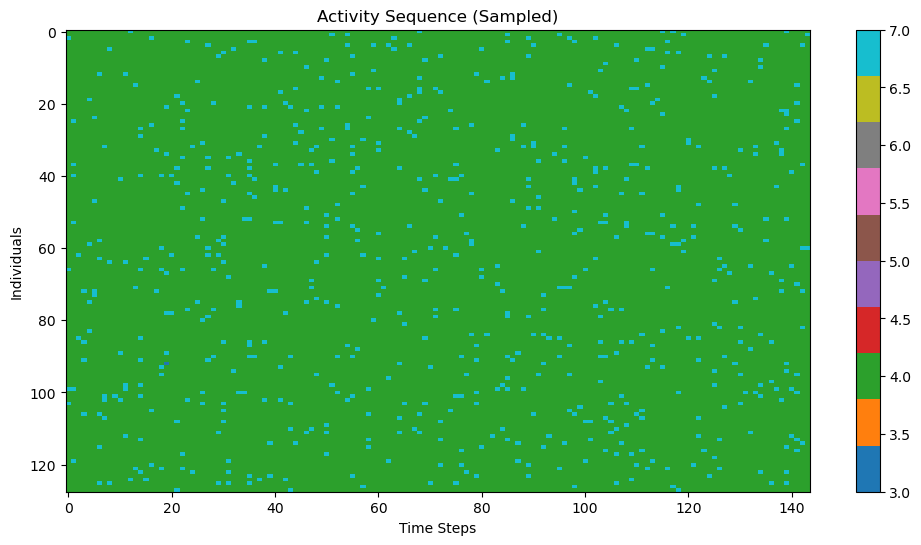

In [23]:
plot_image_grid(discrete_activities.to("cpu"), title="Activity Sequence (Sampled)")